# Assignment 3 V2

First, 2 datasets -> 2 Clustering Algorithms
Next, reduce datasets using DRAs
All 8 DR-datasets -> 2 Clustering Algorithms (Report one of the DRAs and manifold for each dataset for 4 demonstrations.)
Choose one dataset and rerun A1 NN with each DRA. (Report on one of the DRAs and manifold performance for 2 total demonstrations.)
Using dataset from 4, use clusters from 1 as a new feature. Rerun the NN using each set of clusters

1. Pick two datasets 
2. Configure EM and KMeans (clalgs)
3. Run test on both clalgs to determine number of clusters - use yellowbrick and silhouette
4. Run these datasets on the two clustering algorihms using optimal clusters
5. Viz using tSNE against the true output

6. Configure all DRAs
7. Run datasets on these the DRAs
8. Viz using tSNE vs orig data

9. Choose num clusters
10. For PCA, look at eigenvalues to pick nclusters
11. For ICA, look at kurtosis to pick nclusters
12. For RP, look at reconstruction error
9. Run these 8 datasets on the clustering algorithms
10. Select which to report on
11. Viz

12. Configure NN model
13. Run all DR-datasets on NN model
14. Select which to report on

15. Using same dataset as (14), run NN model with cluster outputs from (3) as features
16. Viz


In [235]:
# Imports

import sklearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import yellowbrick.cluster
import scipy
import math
import pandas as pd
import seaborn as sn
import time

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import KernelPCA

from sklearn.datasets import load_breast_cancer #(569, 30, 2)
from sklearn.datasets import load_wine #(178, 13, 3)
from sklearn.datasets import load_iris #(150, 4, 3)
from sklearn.datasets import load_diabetes #(442, 10, 322)
from sklearn.datasets import load_digits #(1797, 64, 10)

from sklearn.datasets import fetch_covtype #(581012, 54, 7)
from sklearn.datasets import fetch_lfw_people #(13233, 5828, 5749)

from sklearn.metrics import accuracy_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer

from scipy.stats import kurtosis

from sklearn.neural_network import MLPClassifier


### Selecting Datasets

In [287]:
# Creating datasets

dataset1 = load_breast_cancer()
dataset2 = load_digits()

data1 = dataset1.data
data2 = dataset2.data

target1 = dataset1.target
target2 = dataset2.target

numTargets1 = np.unique(target1).size
numTargets2 = np.unique(target2).size

numSamples1 = data1.shape[0]
numSamples2 = data2.shape[0]

numFeatures1 = data1.shape[1]
numFeatures2 = data2.shape[1]

nSearch1 = int(np.sqrt(numSamples1))
nSearch2 = int(np.sqrt(numSamples2))

dataname1 = "Breast Cancer Data"
dataname2 = "Digit Data"

Text(0.5, 1.0, 'Digit Data')

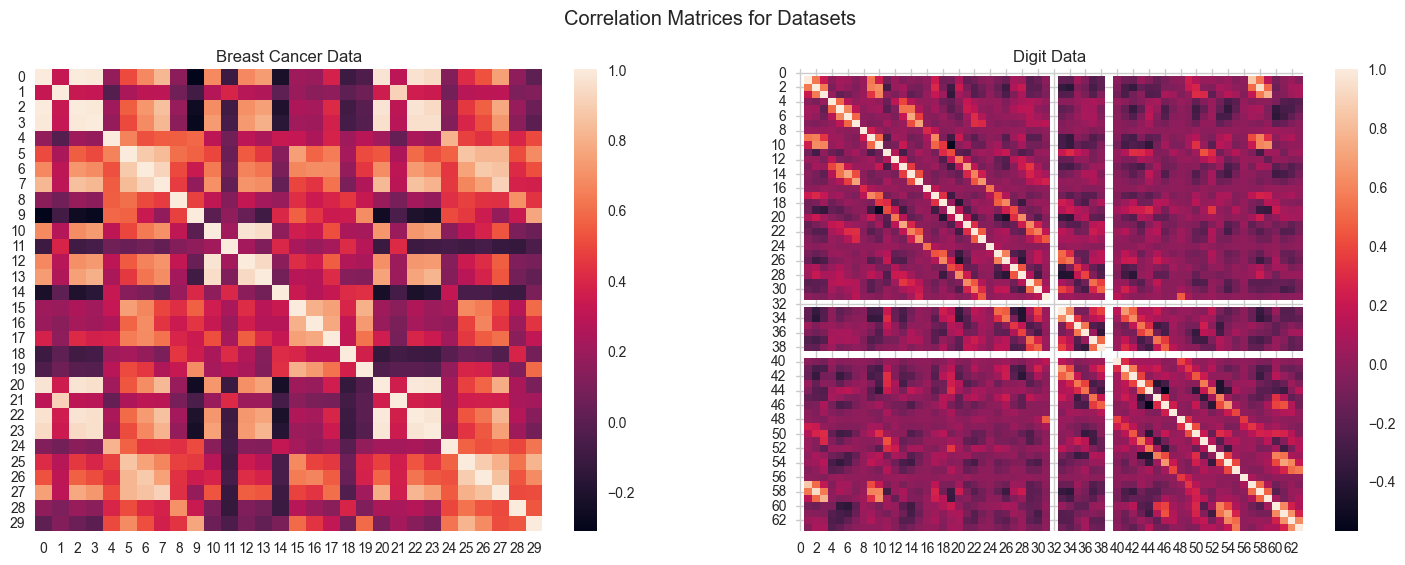

In [288]:
# Dataset 2
df1 = pd.DataFrame(data1).corr()
df2 = pd.DataFrame(data2).corr()

fig,  (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)
sn.heatmap(df1, ax=ax1)
sn.heatmap(df2, ax=ax2)
fig.suptitle('Correlation Matrices for Datasets')
ax1.set_title(dataname1)
ax2.set_title(dataname2)

### Correlation Matrix Eval

In [136]:
# Net Correlation
print((np.sum(pd.DataFrame.to_numpy(abs(df1))[~np.isnan(df1)]) - numFeatures1)/2/numFeatures1/numFeatures1)
print((np.sum(pd.DataFrame.to_numpy(abs(df2))[~np.isnan(df2)]) - numFeatures2)/2/numFeatures2/numFeatures2)

0.19086670235685768
0.054844981183734196


### Selecting Number of components

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

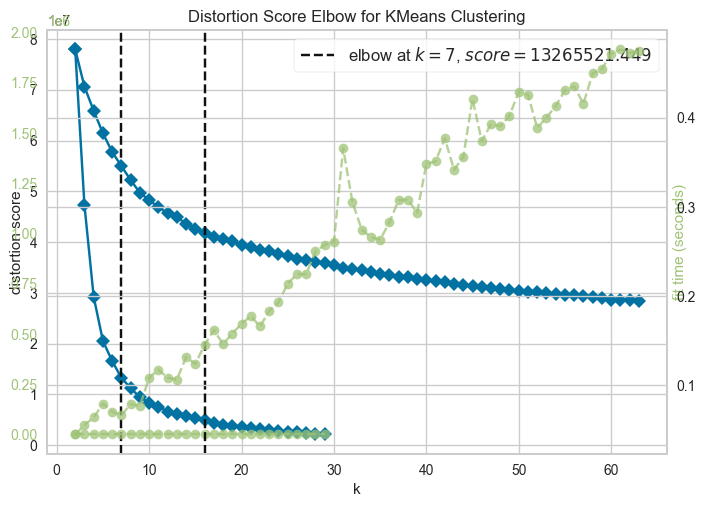

In [137]:
# Selecting k for kMeans

startIndex = 2

model = KMeans()
visualizer1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer1.fit(data1)
visualizer2.fit(data2)

visualizer1.show()
visualizer2.show()

k1 = visualizer1.elbow_value_
k2 = visualizer2.elbow_value_

In [274]:
print(k1, k2)

7 16


In [138]:
# Select n_comp for GMM
def gmm_sil_score(estimator, X):
    return silhouette_score(X, estimator.fit_predict(X))

mm_data1 = MinMaxScaler().fit_transform(data1)
mm_data2 = MinMaxScaler().fit_transform(data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

gmm1 = grid_search1.best_params_['n_components']
gmm2 = grid_search2.best_params_['n_components']

In [270]:
print(grid_search1.best_score_)
print(grid_search2.best_score_)

0.5414741210931551
0.3688332798817967


### Configuring Clustering Algorithms

In [139]:
# Configure EM
em1 = GaussianMixture(n_components=gmm1, random_state=1).fit(data1)
em2 = GaussianMixture(n_components=gmm2, random_state=1).fit(data2)

In [140]:
# Configure k-Means
km1 = KMeans(n_clusters=k1).fit(data1)
km2 = KMeans(n_clusters=k2).fit(data2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [141]:
# Make Predictions
em1Pred = em1.predict(data1)
em2Pred = em2.predict(data2)

km1Pred = km1.predict(data1)
km2Pred = km2.predict(data2)

In [142]:
# Calculate Model Accuracy
em1Accuracy = homogeneity_score(em1Pred, target1)
em2Accuracy = homogeneity_score(em2Pred, target2)

km1Accuracy = homogeneity_score(km1Pred, target1)
km2Accuracy = homogeneity_score(km2Pred, target2)

In [143]:
# See Accuracy
print(em1Accuracy, em2Accuracy)
print(km1Accuracy, km2Accuracy)

0.7092182790386102 0.6961094295284207
0.24682221593895762 0.7244999694022572


Text(0, 0.5, 'axis 8')

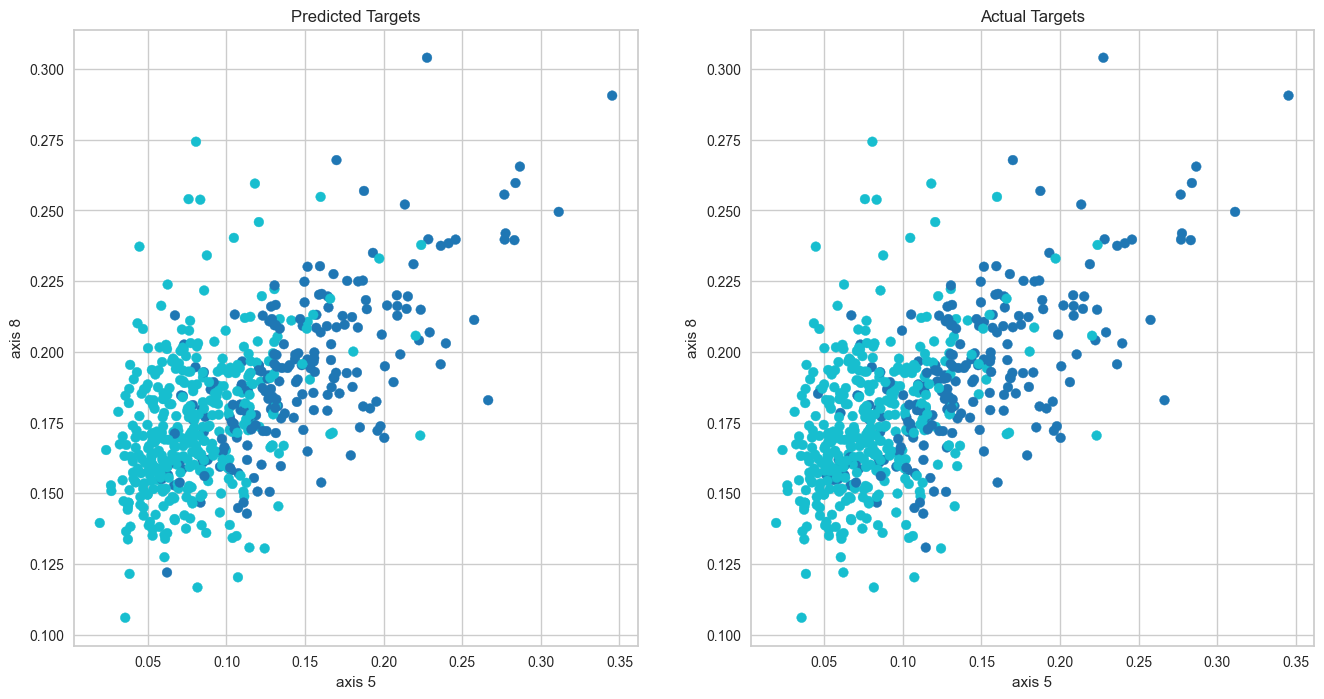

In [265]:
# Basic 2-D Viz
colors = em1Pred

figData = data1
figTarget = target1
axis1 = 5
axis2 = 8

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(figData.T[axis1].T, figData.T[axis2].T, c=colors, cmap='tab10')
ax.set_title("Predicted Targets")
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData.T[axis1].T, figData.T[axis2].T, c=figTarget, cmap='tab10')
ax2.set_title("Actual Targets")
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

Text(0, 0.5, 'axis 1')

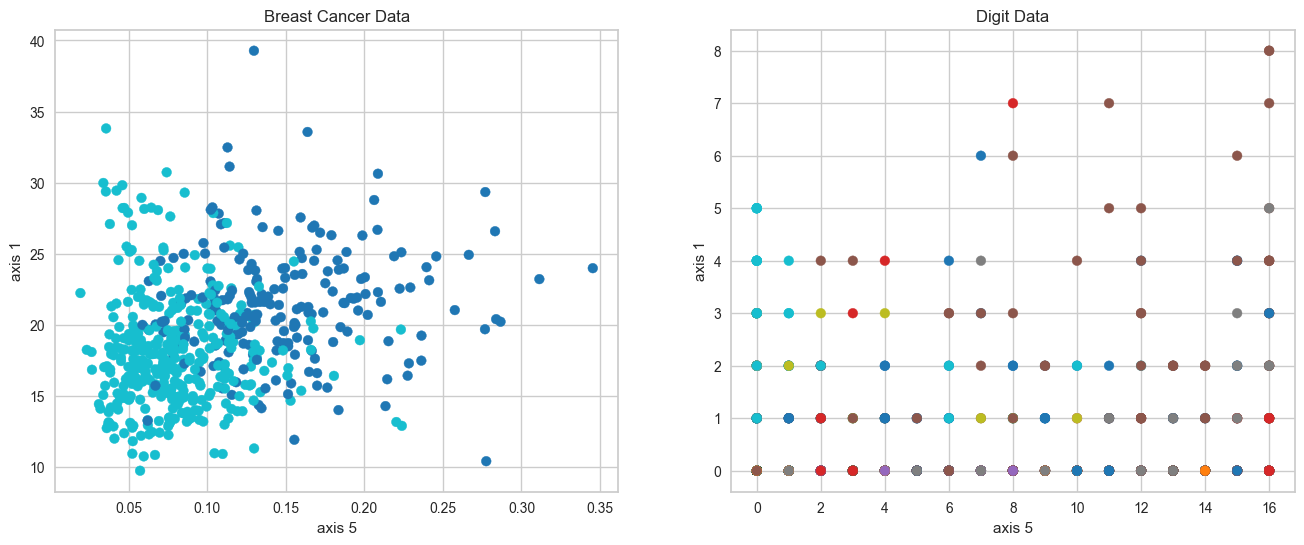

In [289]:
# Basic 2-D Viz V2
colors1 = em1Pred
colors2 = em2Pred

figData1 = data1
figData2 = data2
axis1 = 5
axis2 = 1

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(figData1.T[axis1].T, figData1.T[axis2].T, c=colors1, cmap='tab10')
ax.set_title(dataname1)
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData2.T[axis1].T, figData2.T[axis2].T, c=colors2, cmap='tab10')
ax2.set_title(dataname2)
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

In [145]:
# tSNE viz
data1_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=3).fit_transform(data1)
print("Completed data 1")
data2_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=3).fit_transform(data2)
print("Completed data 2")

Completed data 1
Completed data 2


Text(0, 0.5, 'axis 1')

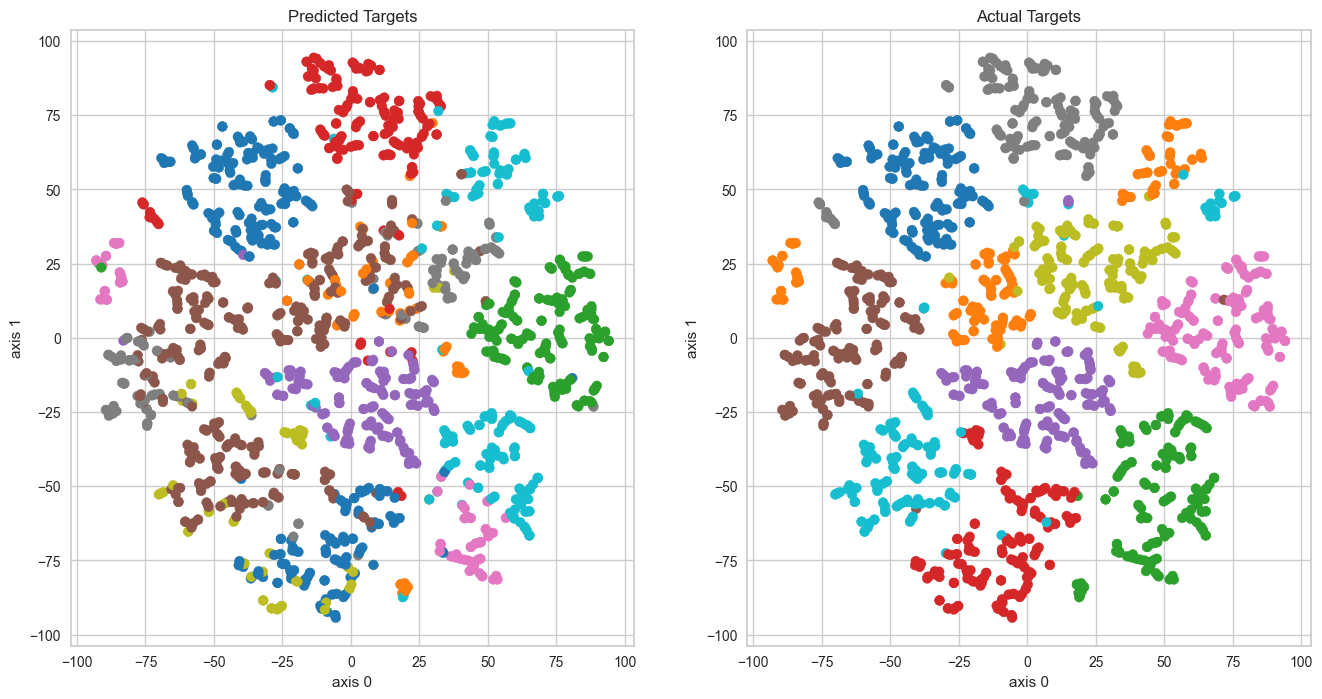

In [146]:
# TSNE Viz

colors = em2Pred

figData = data2_embedded
figTarget = target2

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(figData.T[0].T, figData.T[1].T, c=colors, cmap='tab10')
ax.set_title("Predicted Targets")
ax.set_xlabel("axis " + str(0))
ax.set_ylabel("axis " + str(1))

ax2 = fig.add_subplot(122)
ax2.scatter(figData.T[0].T, figData.T[1].T, c=figTarget, cmap='tab10')
ax2.set_title("Actual Targets")
ax2.set_xlabel("axis " + str(0))
ax2.set_ylabel("axis " + str(1))

### Dimension Reduction Algorithms

In [281]:
# PCA scoring with explained variance
def pca_score(estimator, X):
    estimator.fit_transform(X)
    return estimator.explained_variance_ratio_.cumsum()

thresh1 = 0.95
dims_pca1 = 0
dims_pca2 = 0

evSum1 = np.zeros(numFeatures1 - startIndex)
evSum2 = np.zeros(numFeatures2 - startIndex)

for i in range(startIndex, numFeatures1):
    ev = pca_score(PCA(n_components=i), data1)
    evSum1[i - startIndex] = ev[-1]
    if ev[-1] > thresh1 and dims_pca1 == 0:
        dims_pca1 = i

for i in range(startIndex, numFeatures2):
    ev = pca_score(PCA(n_components=i), data2)
    evSum2[i - startIndex] = ev[-1]
    if ev[-1] > thresh1 and dims_pca2 == 0:
        dims_pca2 = i
print(dims_pca1)
print(dims_pca2)

2
29


Text(0, 0.5, 'Explained Variance Ratio Cumulative Sum')

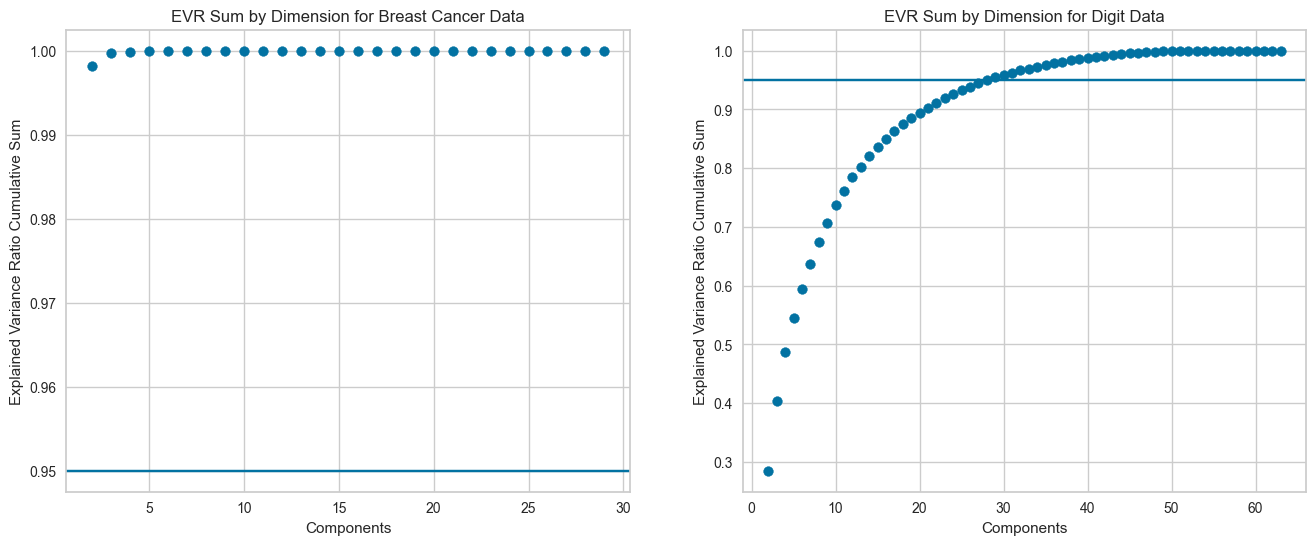

In [293]:
# Explained Variance Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(np.arange(evSum1.size) + 2, evSum1)
ax.axhline(y=thresh1)
ax.set_title("EVR Sum by Dimension for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Explained Variance Ratio Cumulative Sum")

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(evSum2.size) + 2, evSum2)
ax2.axhline(y=thresh1)
ax2.set_title("EVR Sum by Dimension for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Explained Variance Ratio Cumulative Sum")

In [149]:
# Configure PCA
pca_data1 = PCA(n_components=dims_pca1).fit_transform(data1)
pca_data2 = PCA(n_components=dims_pca2).fit_transform(data2)

In [285]:
# ICA scoring with kurtosis
def kurtosis_score(estimator, comps, X):
    return np.mean(np.abs(kurtosis(estimator(n_components=comps).fit_transform(X))))

kurtosisScores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    kurtosisScores1[i - startIndex] = kurtosis_score(FastICA, i, data1)

kurtosisScores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    kurtosisScores2[i - startIndex] = kurtosis_score(FastICA, i, data2)

dims_ica1 = np.argmax(kurtosisScores1) + startIndex
dims_ica2 = np.argmax(kurtosisScores2) + startIndex

print(dims_ica1)
print(dims_ica2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_q

3
61


C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Text(0, 0.5, 'Kurtosis')

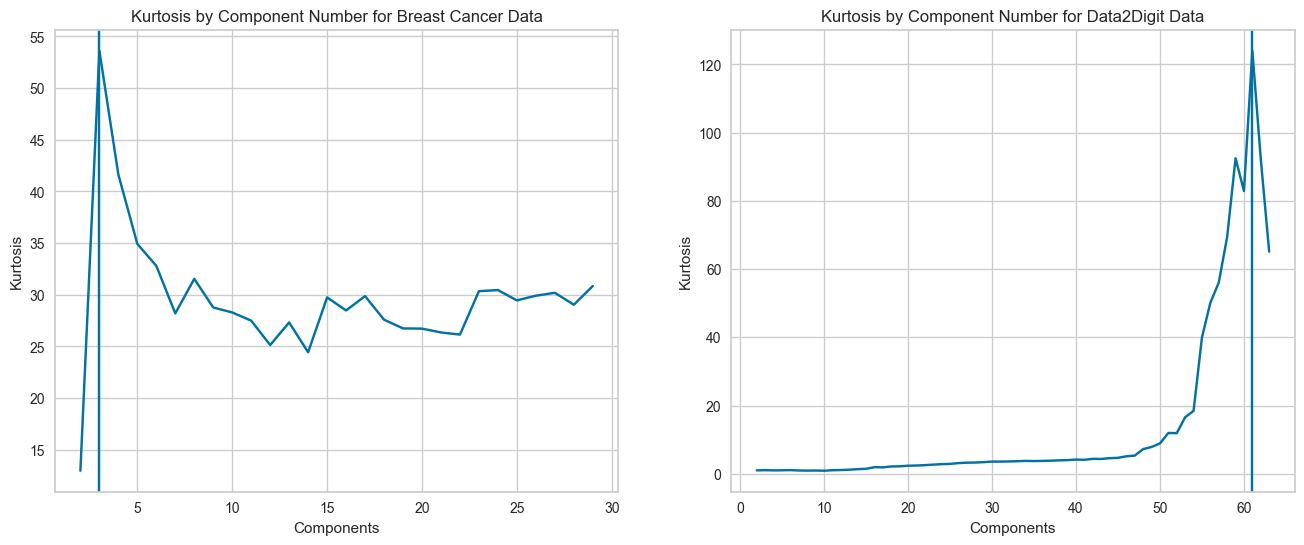

In [296]:
# Kurtosis Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(kurtosisScores1.size) + startIndex, kurtosisScores1)
ax.axvline(dims_ica1)
ax.set_title("Kurtosis by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Kurtosis")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(kurtosisScores2.size) + startIndex, kurtosisScores2)
ax2.axvline(dims_ica2)
ax2.set_title("Kurtosis by Component Number for Data2" + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Kurtosis")

In [152]:
# Configure ICA
ica_data1 = FastICA(n_components=dims_ica1).fit_transform(data1)
ica_data2 = FastICA(n_components=dims_ica2).fit_transform(data2)

In [153]:
# Configure Reconstruction Score
randomStates = [1, 2, 3, 4, 5]
def reconstruction_score(m, n, X):
    totalLoss = 0
    for rs in randomStates:
        model = m(n_components=n, compute_inverse_components=True, random_state=rs)
        model.fit(X)
        trained = model.transform(X)
        data_projected = np.matmul(X, model.inverse_components_)
        totalLoss += np.sum((trained - data_projected) ** 2, axis=1).mean()
    return totalLoss / len(randomStates)

In [298]:
# Calculate Reconstruction Score
reconstructionScores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    reconstructionScores1[i - startIndex] = reconstruction_score(GaussianRandomProjection, i, data1)

reconstructionScores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    reconstructionScores2[i - startIndex] = reconstruction_score(GaussianRandomProjection, i, data2)

dims_rp1 = np.argmin(reconstructionScores1) + startIndex
dims_rp2 = np.argmin(reconstructionScores2) + startIndex
print(dims_rp1)
print(dims_rp2)

4
25


Text(0, 0.5, 'Reconstruction Loss')

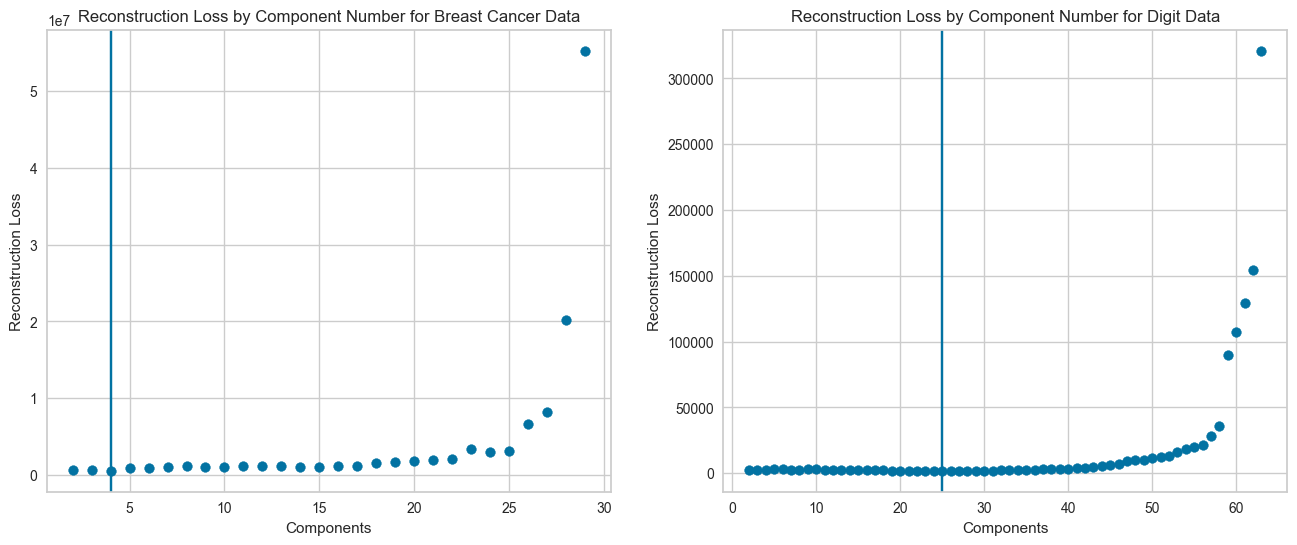

In [300]:
# Reconstruction Loss Viz
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.scatter(np.arange(reconstructionScores1.size) + startIndex, reconstructionScores1)
ax.axvline(dims_rp1)
ax.set_title("Reconstruction Loss by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Reconstruction Loss")

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(reconstructionScores2.size) + startIndex, reconstructionScores2)
ax2.axvline(dims_rp2)
ax2.set_title("Reconstruction Loss by Component Number for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Reconstruction Loss")

In [156]:
# Configure Random Projections
rp_data1 = GaussianRandomProjection(n_components=dims_rp1).fit_transform(data1)
rp_data2 = GaussianRandomProjection(n_components=dims_rp2).fit_transform(data2)

In [157]:
# Configure Kernel Score
data1_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=3).fit_transform(data1)
print("Completed data 1")
data2_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=3).fit_transform(data2)
print("Completed data 2")

Completed data 1
Completed data 2


In [158]:
# Find dimensions for kpca

thresh = 0.99999

dims_kpca1 = 0
dims_kpca2 = 0

evr1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    model = KernelPCA(n_components=i, kernel='poly', degree=3)
    trans1 = model.fit_transform(data1)
    ev = np.var(trans1, axis=0)
    evCumsum = np.cumsum(ev/np.sum(ev))
    print(evCumsum)
    evr1[i - startIndex] = evCumsum[-1]
    print(evr1[i - startIndex])
    if evr1[i - startIndex] > thresh and dims_kpca1 == 0:
        dims_kpca1 = i
        break

evr2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    model = KernelPCA(n_components=i, kernel='poly', degree=3)
    trans2 = model.fit_transform(data2)
    ev = np.var(trans2, axis=0)
    evCumsum = np.cumsum(ev/np.sum(ev))
    print(evCumsum)
    evr2[i - startIndex] = evCumsum[-1]
    print(evr2[i - startIndex])
    if evr2[i - startIndex] > thresh and dims_kpca2 == 0:
        dims_kpca2 = i
        break

print(evr1)
print(evr2)

print(dims_kpca1)
print(dims_kpca2)

[0.98003243 1.        ]
1.0
[0.51721218 1.        ]
1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
2


In [159]:
# Construct Scree Plot

model1 = KernelPCA(n_components=numFeatures1, kernel='poly', degree=3)
model1.fit_transform(data1)
eigs1 = model1.eigenvalues_

model2 = KernelPCA(n_components=numFeatures2, kernel='poly', degree=3)
model2.fit_transform(data2)
eigs2 = model2.eigenvalues_

2
25


Text(0, 0.5, 'Eigenvalue')

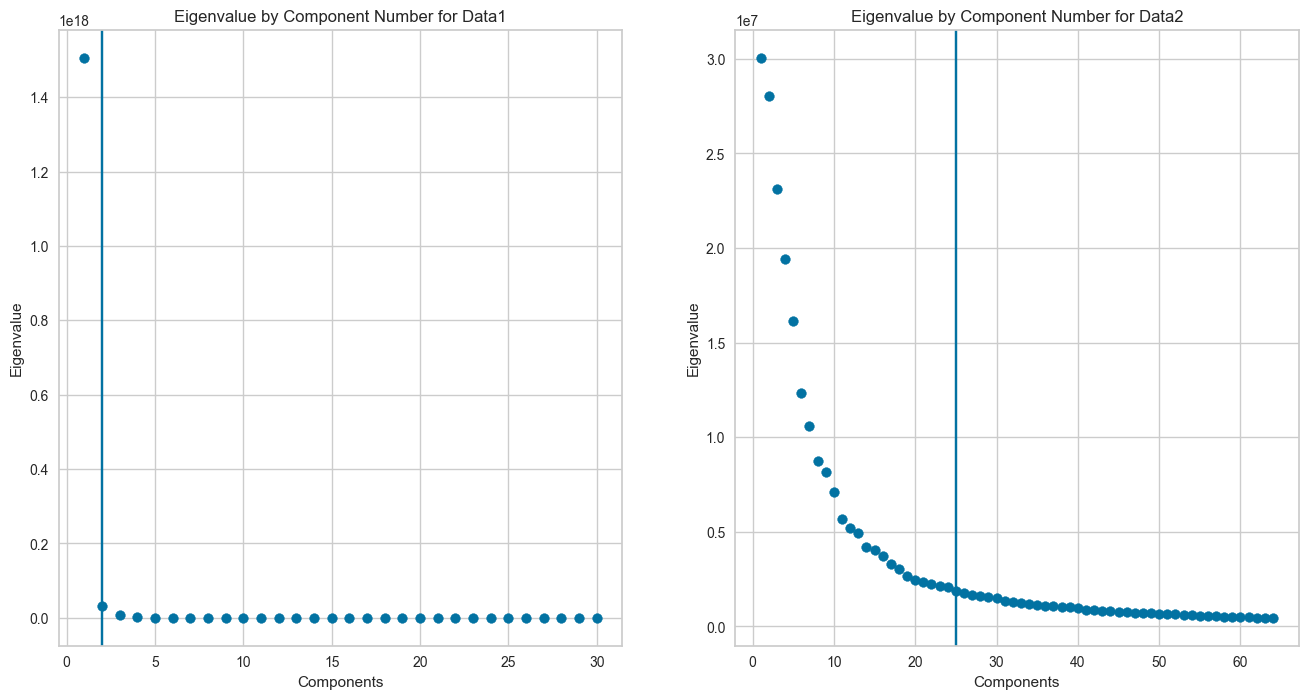

In [160]:
# Eigenvalue Viz

dims_kpca1 = 2
dims_kpca2 = 25

print(dims_kpca1)
print(dims_kpca2)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(np.arange(len(eigs1)) + 1, eigs1)
ax.axvline(x=dims_kpca1)
ax.set_title("Eigenvalue by Component Number for Data1")
ax.set_xlabel("Components")
ax.set_ylabel("Eigenvalue")

ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(len(eigs2)) + 1, eigs2)
ax2.axvline(x=dims_kpca2)
ax2.set_title("Eigenvalue by Component Number for Data2")
ax2.set_xlabel("Components")
ax2.set_ylabel("Eigenvalue")

In [301]:
# Configure Kernel PCA
kpca_data1 = KernelPCA(n_components=dims_kpca1, kernel='poly', degree=3).fit_transform(data1)
kpca_data2 = KernelPCA(n_components=dims_kpca2, kernel='poly', degree=3).fit_transform(data2)

In [305]:
# Find Parameters for Iso
rscores1 = np.zeros(numFeatures1 - startIndex)
for i in range(startIndex, numFeatures1):
    model = Isomap(n_components=i)
    model.fit(data1)
    trans = model.transform(data1)
    rscores1[i - startIndex] = model.reconstruction_error()

rscores2 = np.zeros(numFeatures2 - startIndex)
for i in range(startIndex, numFeatures2):
    model = Isomap(n_components=i)
    model.fit(data2)
    trans = model.transform(data2)
    rscores2[i - startIndex] = model.reconstruction_error()

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might

Text(0, 0.5, 'Reconstruction Score')

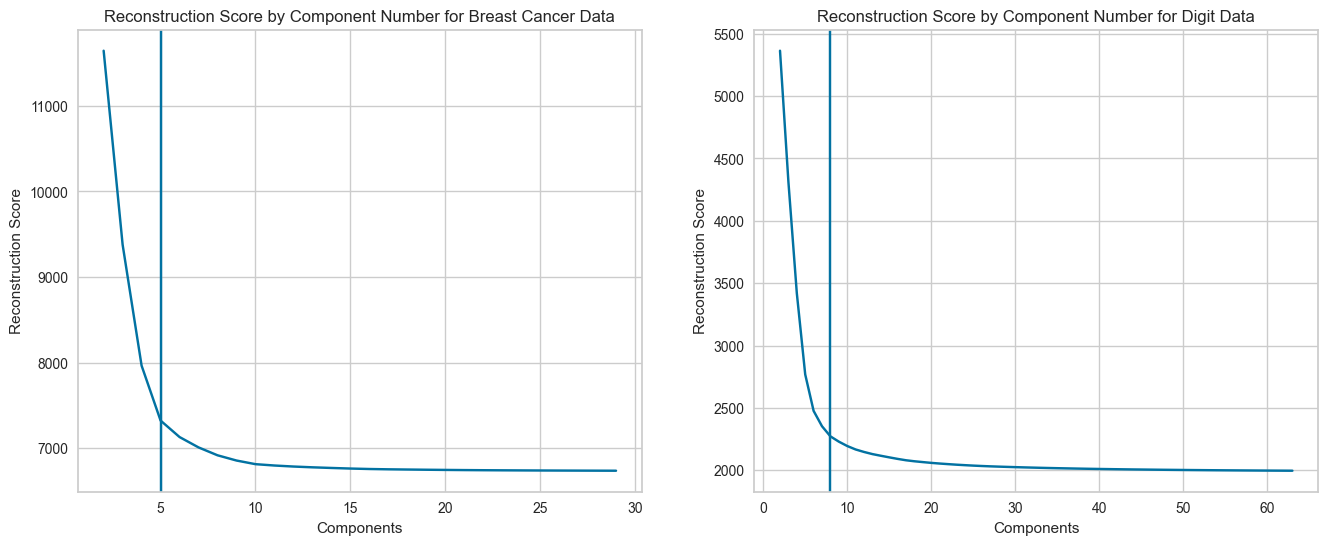

In [311]:
# Viz Reconstruction error
dims_iso1 = 5
dims_iso2 = 8
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(len(rscores1)) + startIndex, rscores1)
ax.axvline(x=dims_iso1)
ax.set_title("Reconstruction Score by Component Number for " + dataname1)
ax.set_xlabel("Components")
ax.set_ylabel("Reconstruction Score")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(rscores2)) + startIndex, rscores2)
ax2.axvline(x=dims_iso2)
ax2.set_title("Reconstruction Score by Component Number for " + dataname2)
ax2.set_xlabel("Components")
ax2.set_ylabel("Reconstruction Score")

In [164]:
# Reduce using Isomap
iso_data1 = Isomap(n_components=dims_iso1).fit_transform(data1)
iso_data2 = Isomap(n_components=dims_iso2).fit_transform(data2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [165]:
# Num dimensions
print("Num dimensions in data after DRA:")
print("Orig: ", numFeatures1, numFeatures2)
print("PCA: ", dims_pca1, dims_pca2)
print("ICA: ", dims_ica1, dims_ica2)
print("RP: ", dims_rp1, dims_rp2)
print("KPCA: ", dims_kpca1, dims_kpca2)
print("ISO: ", dims_iso1, dims_iso2)

Num dimensions in data after DRA:
Orig:  30 64
PCA:  3 49
ICA:  3 61
RP:  4 25
KPCA:  2 25
ISO:  6 16


### Clustering on DRA's

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

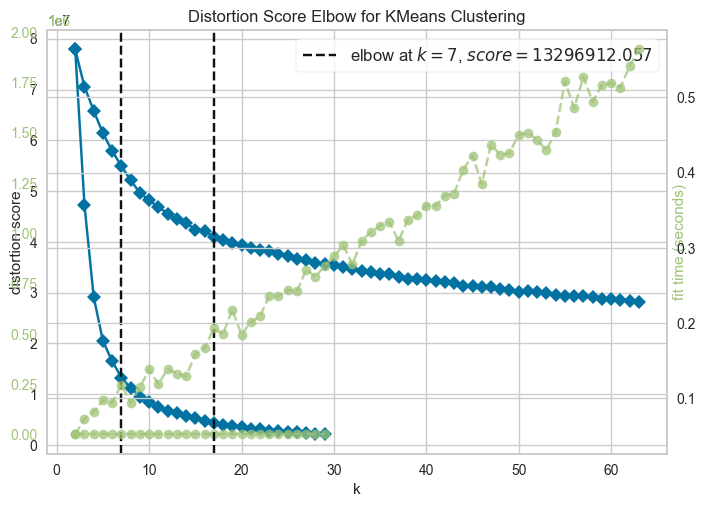

In [166]:
# Find n_components for kmeans, pca

model = KMeans()
visualizer_pca1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_pca2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_pca1.fit(pca_data1)
visualizer_pca2.fit(pca_data2)

visualizer_pca1.show()
visualizer_pca2.show()

k_pca1 = visualizer_pca1.elbow_value_
k_pca2 = visualizer_pca2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

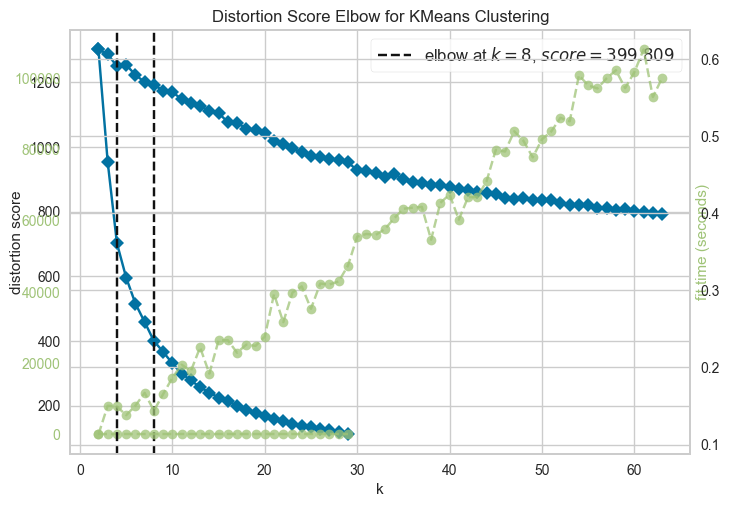

In [167]:
# Find n_components for kmeans, ica

visualizer_ica1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_ica2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_ica1.fit(ica_data1)
visualizer_ica2.fit(ica_data2)

visualizer_ica1.show()
visualizer_ica2.show()

k_ica1 = visualizer_ica1.elbow_value_
k_ica2 = visualizer_ica2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

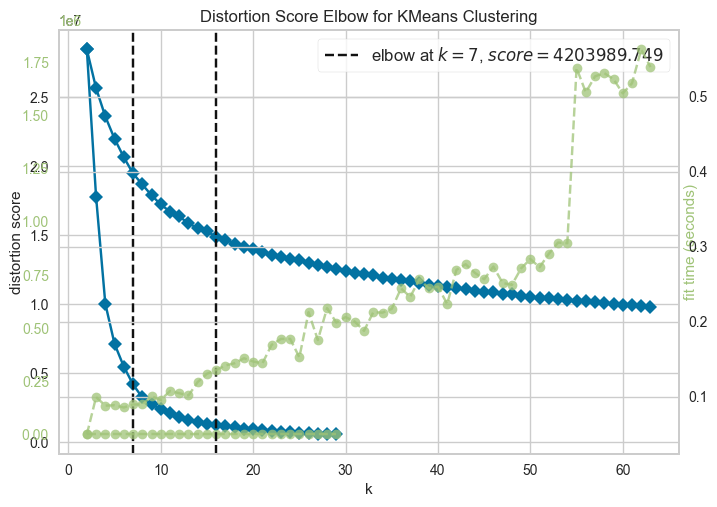

In [168]:
# Find n_components for kmeans, rp

visualizer_rp1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_rp2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_rp1.fit(rp_data1)
visualizer_rp2.fit(rp_data2)

visualizer_rp1.show()
visualizer_rp2.show()

k_rp1 = visualizer_rp1.elbow_value_
k_rp2 = visualizer_rp2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

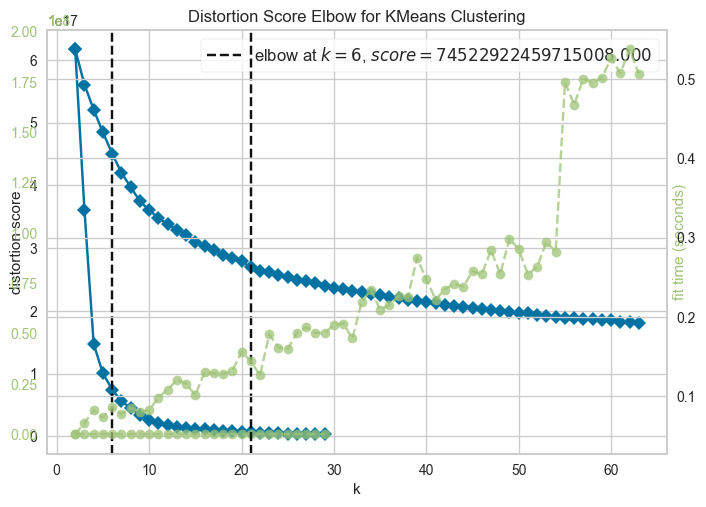

In [169]:
# Find n_components for kmeans, kpca

visualizer_kpca1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_kpca2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_kpca1.fit(kpca_data1)
visualizer_kpca2.fit(kpca_data2)

visualizer_kpca1.show()
visualizer_kpca2.show()

k_kpca1 = visualizer_kpca1.elbow_value_
k_kpca2 = visualizer_kpca2.elbow_value_

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

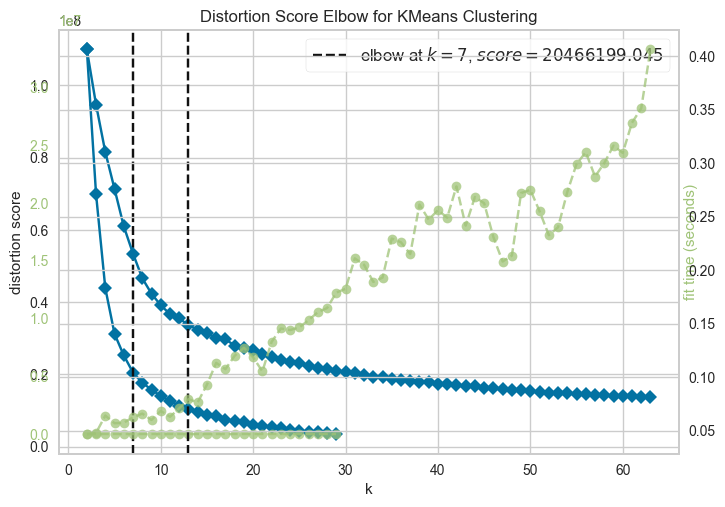

In [170]:
# Find n_components for kmeans, iso

visualizer_iso1 = KElbowVisualizer(model, k=(startIndex, numFeatures1))
visualizer_iso2 = KElbowVisualizer(model, k=(startIndex, numFeatures2))

visualizer_iso1.fit(iso_data1)
visualizer_iso2.fit(iso_data2)

visualizer_iso1.show()
visualizer_iso2.show()

k_iso1 = visualizer_iso1.elbow_value_
k_iso2 = visualizer_iso2.elbow_value_

In [171]:
# Select n_comp for GMM , pca
mm_data1 = MinMaxScaler().fit_transform(pca_data1)
mm_data2 = MinMaxScaler().fit_transform(pca_data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

pca_gmm1 = grid_search1.best_params_['n_components']
pca_gmm2 = grid_search2.best_params_['n_components']

In [172]:
# Select n_comp for GMM , ica
mm_data1 = MinMaxScaler().fit_transform(ica_data1)
mm_data2 = MinMaxScaler().fit_transform(ica_data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

ica_gmm1 = grid_search1.best_params_['n_components']
ica_gmm2 = grid_search2.best_params_['n_components']

In [173]:
# Select n_comp for GMM , rp
mm_data1 = MinMaxScaler().fit_transform(rp_data1)
mm_data2 = MinMaxScaler().fit_transform(rp_data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

rp_gmm1 = grid_search1.best_params_['n_components']
rp_gmm2 = grid_search2.best_params_['n_components']

In [174]:
# Select n_comp for GMM , kpca
mm_data1 = MinMaxScaler().fit_transform(kpca_data1)
mm_data2 = MinMaxScaler().fit_transform(kpca_data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

kpca_gmm1 = grid_search1.best_params_['n_components']
kpca_gmm2 = grid_search2.best_params_['n_components']

In [175]:
# Select n_comp for GMM , iso
mm_data1 = MinMaxScaler().fit_transform(iso_data1)
mm_data2 = MinMaxScaler().fit_transform(iso_data2)

nums1 = np.zeros(numFeatures1)
nums2 = np.zeros(numFeatures2)

param_grid1 = {"n_components" : range(2, numFeatures1)}
grid_search1 = GridSearchCV(GaussianMixture(), param_grid=param_grid1, scoring=gmm_sil_score)
grid_search1.fit(mm_data1)

param_grid2 = {"n_components" : range(2, numFeatures2)}
grid_search2 = GridSearchCV(GaussianMixture(), param_grid=param_grid2, scoring=gmm_sil_score)
grid_search2.fit(mm_data2)

iso_gmm1 = grid_search1.best_params_['n_components']
iso_gmm2 = grid_search2.best_params_['n_components']

In [176]:
print("Num Clusters in data: ")
print("Orig", numTargets1, numTargets2)
print("PCA, GMM: ", pca_gmm1, pca_gmm2)
print("PCA, KM: ", k_pca1, k_pca2)
print("ICA, GMM: ", ica_gmm1, ica_gmm2)
print("ICA, KM: ", k_ica1, k_ica2)
print("RP, GMM: ", rp_gmm1, rp_gmm2)
print("RP, KM: ", k_rp1, k_rp2)
print("KPCA, GMM: ", kpca_gmm1, kpca_gmm2)
print("KPCA, KM: ", k_kpca1, k_kpca2)
print("iso, GMM: ", iso_gmm1, iso_gmm2)
print("iso, KM: ", k_iso1, k_iso2)

Num Clusters in data: 
Orig 2 10
PCA, GMM:  2 31
PCA, KM:  7 17
ICA, GMM:  2 55
ICA, KM:  8 4
RP, GMM:  2 21
RP, KM:  7 16
KPCA, GMM:  2 24
KPCA, KM:  6 21
iso, GMM:  2 28
iso, KM:  7 13


### Refitting with Reduced Data

In [177]:
# Configure EM, DRA
pca_em1Pred = GaussianMixture(n_components=pca_gmm1, random_state=1).fit_predict(pca_data1)
pca_em2Pred = GaussianMixture(n_components=pca_gmm2, random_state=1).fit_predict(pca_data2)

ica_em1Pred = GaussianMixture(n_components=ica_gmm1, random_state=1).fit_predict(ica_data1)
ica_em2Pred = GaussianMixture(n_components=ica_gmm2, random_state=1).fit_predict(ica_data2)

rp_em1Pred = GaussianMixture(n_components=rp_gmm1, random_state=1).fit_predict(rp_data1)
rp_em2Pred = GaussianMixture(n_components=rp_gmm2, random_state=1).fit_predict(rp_data2)

kpca_em1Pred = GaussianMixture(n_components=kpca_gmm1, random_state=1).fit_predict(kpca_data1)
kpca_em2Pred = GaussianMixture(n_components=kpca_gmm2, random_state=1).fit_predict(kpca_data2)

iso_em1Pred = GaussianMixture(n_components=iso_gmm1, random_state=1).fit_predict(iso_data1)
iso_em2Pred = GaussianMixture(n_components=iso_gmm2, random_state=1).fit_predict(iso_data2)

In [178]:
# Configure k-Means, DRA
pca_km1Pred = KMeans(n_clusters=k_pca1).fit_predict(pca_data1)
pca_km2Pred = KMeans(n_clusters=k_pca2).fit_predict(pca_data2)

ica_km1Pred = KMeans(n_clusters=k_ica1).fit_predict(ica_data1)
ica_km2Pred = KMeans(n_clusters=k_ica2).fit_predict(ica_data2)

rp_km1Pred = KMeans(n_clusters=k_rp1).fit_predict(rp_data1)
rp_km2Pred = KMeans(n_clusters=k_rp2).fit_predict(rp_data2)

kpca_km1Pred = KMeans(n_clusters=k_kpca1).fit_predict(kpca_data1)
kpca_km2Pred = KMeans(n_clusters=k_kpca2).fit_predict(kpca_data2)

iso_km1Pred = KMeans(n_clusters=k_iso1).fit_predict(iso_data1)
iso_km2Pred = KMeans(n_clusters=k_iso2).fit_predict(iso_data2)

C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ashi9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

In [179]:
# Accuracies
pca_em1Accuracy = homogeneity_score(pca_em1Pred, target1)
pca_em2Accuracy = homogeneity_score(pca_em2Pred, target2)
pca_km1Accuracy = homogeneity_score(pca_km1Pred, target1)
pca_km2Accuracy = homogeneity_score(pca_km2Pred, target2)

ica_em1Accuracy = homogeneity_score(ica_em1Pred, target1)
ica_em2Accuracy = homogeneity_score(ica_em2Pred, target2)
ica_km1Accuracy = homogeneity_score(ica_km1Pred, target1)
ica_km2Accuracy = homogeneity_score(ica_km2Pred, target2)

rp_em1Accuracy = homogeneity_score(rp_em1Pred, target1)
rp_em2Accuracy = homogeneity_score(rp_em2Pred, target2)
rp_km1Accuracy = homogeneity_score(rp_km1Pred, target1)
rp_km2Accuracy = homogeneity_score(rp_km2Pred, target2)

kpca_em1Accuracy = homogeneity_score(kpca_em1Pred, target1)
kpca_em2Accuracy = homogeneity_score(kpca_em2Pred, target2)
kpca_km1Accuracy = homogeneity_score(kpca_km1Pred, target1)
kpca_km2Accuracy = homogeneity_score(kpca_km2Pred, target2)

iso_em1Accuracy = homogeneity_score(iso_em1Pred, target1)
iso_em2Accuracy = homogeneity_score(iso_em2Pred, target2)
iso_km1Accuracy = homogeneity_score(iso_km1Pred, target1)
iso_km2Accuracy = homogeneity_score(iso_km2Pred, target2)

In [180]:
print(em1Accuracy, em2Accuracy, km1Accuracy, km2Accuracy)
print(pca_em1Accuracy, pca_em2Accuracy, pca_km1Accuracy, pca_km2Accuracy)
print(ica_em1Accuracy, ica_em2Accuracy, ica_km1Accuracy, ica_km2Accuracy)
print(rp_em1Accuracy, rp_em2Accuracy, rp_km1Accuracy, rp_km2Accuracy)
print(kpca_em1Accuracy, kpca_em2Accuracy, kpca_km1Accuracy, kpca_km2Accuracy)
print(iso_em1Accuracy, iso_em2Accuracy, iso_km1Accuracy, iso_km2Accuracy)

0.7092182790386102 0.6961094295284207 0.24682221593895762 0.7244999694022572
0.5818352498410015 0.6158201699302971 0.24699173314672135 0.7224870163886974
0.5786406574435053 0.47456268239449 0.2148159053735939 0.34215148436695825
0.6284153650580175 0.6329396223381151 0.22964907225836018 0.583845676779613
0.13465572079301322 0.6503883651780151 0.33723243479841297 0.6369385406110404
0.5236558801591958 0.6951426414369073 0.24825810615742824 0.8196062896145707


Text(0, 0.5, 'axis 10')

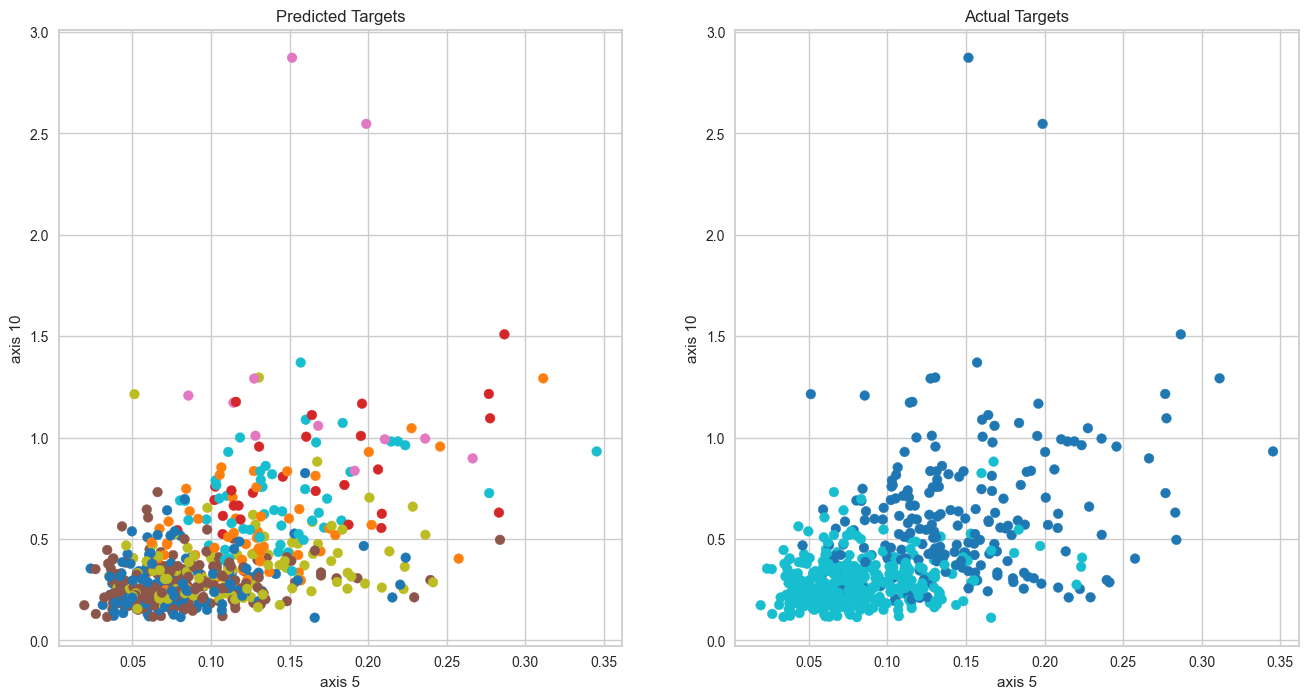

In [184]:
colors = pca_km1Pred

figData = data1
figTarget = target1
axis1 = 5
axis2 = 10

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(figData.T[axis1].T, figData.T[axis2].T, c=colors, cmap='tab10')
ax.set_title("Predicted Targets")
ax.set_xlabel("axis " + str(axis1))
ax.set_ylabel("axis " + str(axis2))

ax2 = fig.add_subplot(122)
ax2.scatter(figData.T[axis1].T, figData.T[axis2].T, c=figTarget, cmap='tab10')
ax2.set_title("Actual Targets")
ax2.set_xlabel("axis " + str(axis1))
ax2.set_ylabel("axis " + str(axis2))

Text(0, 0.5, 'Accuracy')

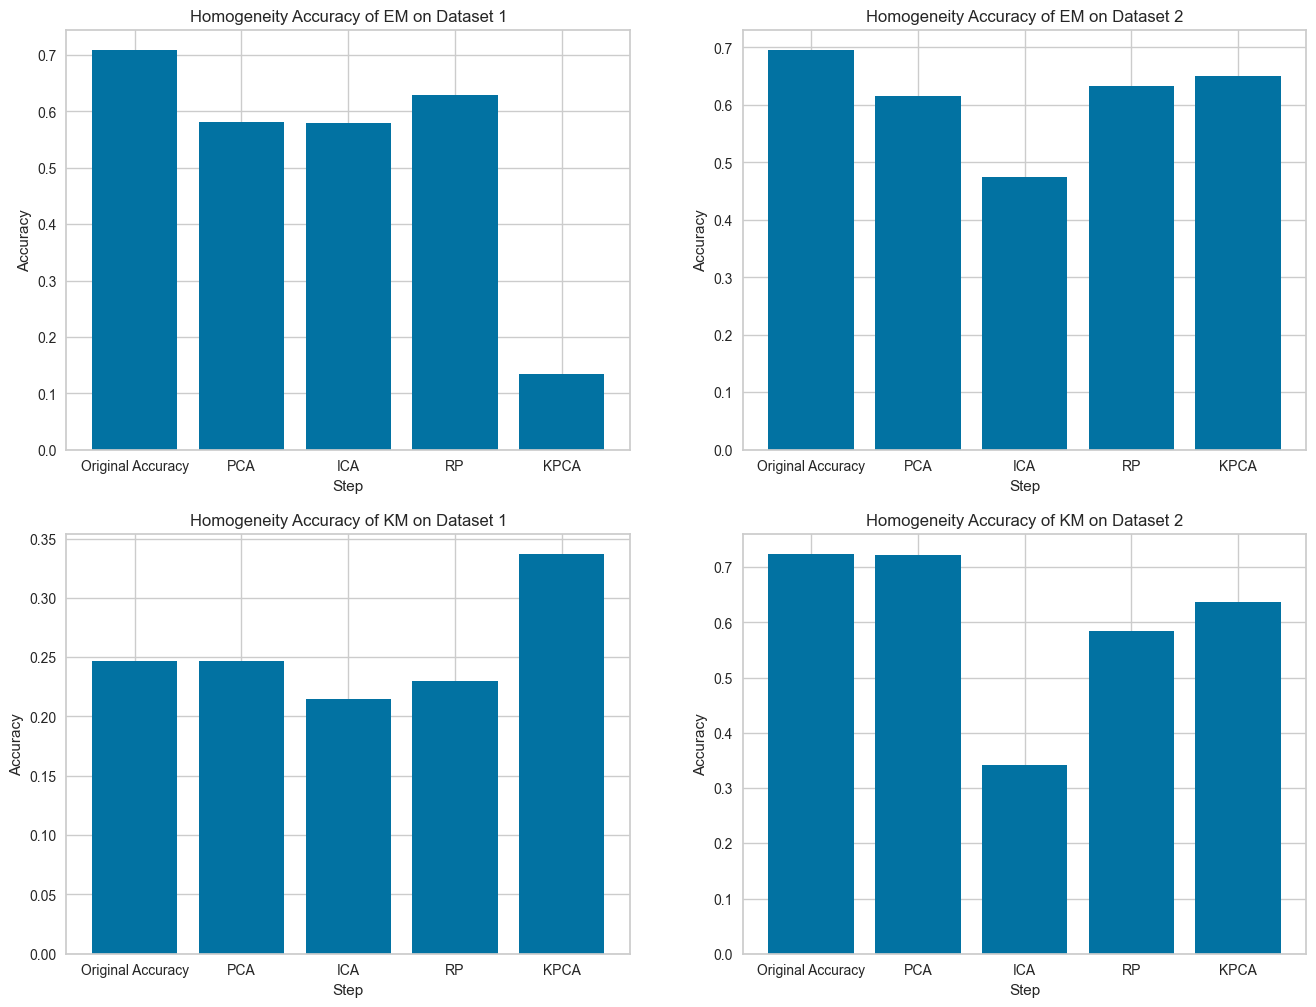

In [182]:
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.bar(["Original Accuracy", "PCA", "ICA", "RP", "KPCA"], [em1Accuracy, pca_em1Accuracy, ica_em1Accuracy, rp_em1Accuracy, kpca_em1Accuracy])
ax.set_title("Homogeneity Accuracy of EM on Dataset 1")
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")

ax2 = fig.add_subplot(222)
ax2.bar(["Original Accuracy", "PCA", "ICA", "RP", "KPCA"], [em2Accuracy, pca_em2Accuracy, ica_em2Accuracy, rp_em2Accuracy, kpca_em2Accuracy])
ax2.set_title("Homogeneity Accuracy of EM on Dataset 2")
ax2.set_xlabel("Step")
ax2.set_ylabel("Accuracy")

ax3 = fig.add_subplot(223)
ax3.bar(["Original Accuracy", "PCA", "ICA", "RP", "KPCA"], [km1Accuracy, pca_km1Accuracy, ica_km1Accuracy, rp_km1Accuracy, kpca_km1Accuracy])
ax3.set_title("Homogeneity Accuracy of KM on Dataset 1")
ax3.set_xlabel("Step")
ax3.set_ylabel("Accuracy")

ax4 = fig.add_subplot(224)
ax4.bar(["Original Accuracy", "PCA", "ICA", "RP", "KPCA"], [km2Accuracy, pca_km2Accuracy, ica_km2Accuracy, rp_km2Accuracy, kpca_km2Accuracy])
ax4.set_title("Homogeneity Accuracy of KM on Dataset 2")
ax4.set_xlabel("Step")
ax4.set_ylabel("Accuracy")

### Neural Network fitting

In [202]:
# Define NN

X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, stratify=target2, random_state=1, train_size=0.5)

model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
lossCurve1 = model.loss_curve_
valScore1 = model.validation_scores_

model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
lossCurve2 = model.loss_curve_
valScore2 = model.validation_scores_

Text(0.5, 0.98, 'Neural Network Performance on Original Data')

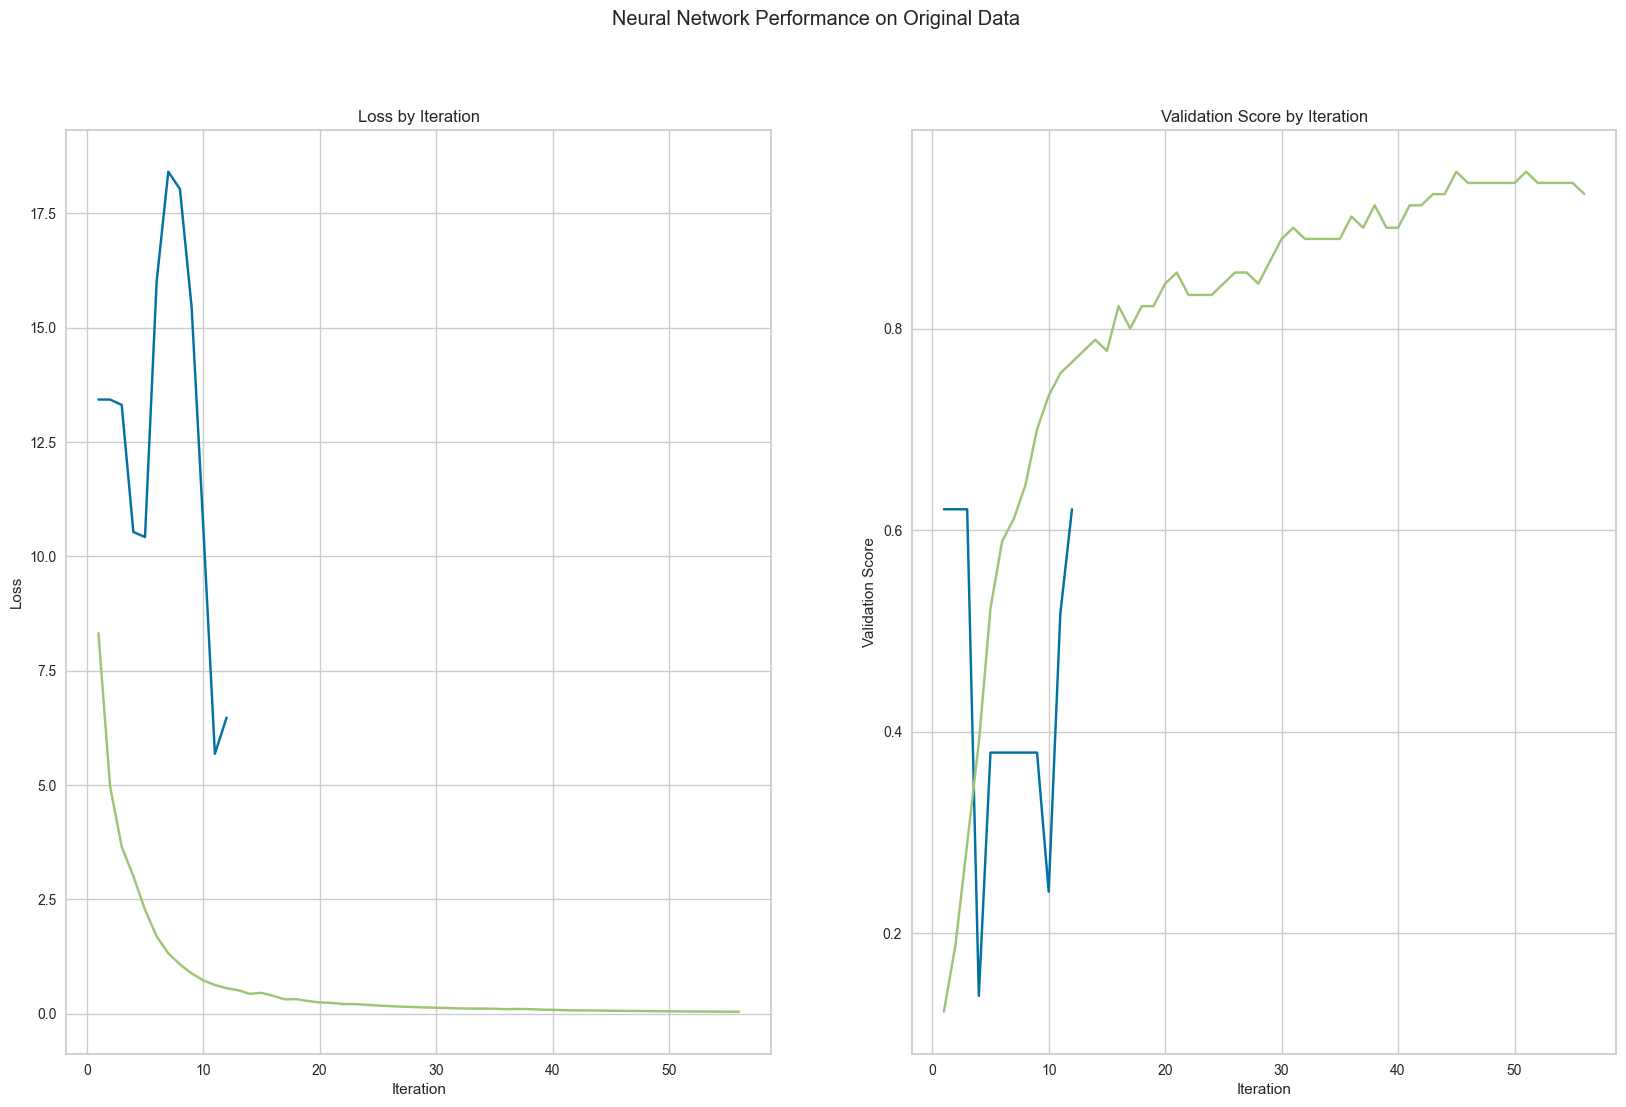

In [201]:
# Orig NN Viz

fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(121)
ax.plot(np.arange(len(lossCurve1)) + 1, lossCurve1)
ax.plot(np.arange(len(lossCurve2)) + 1, lossCurve2)
ax.set_title("Loss by Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(valScore1)) + 1, valScore1)
ax2.plot(np.arange(len(valScore2)) + 1, valScore2)
ax2.set_title("Validation Score by Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Original Data")

In [238]:
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True)
train_sizes = np.arange(20, 81)/100
train_size_abs, train_scores, test_scores = learning_curve(model, data1, target1, train_sizes=train_sizes)

Text(0, 0.5, 'Test Score')

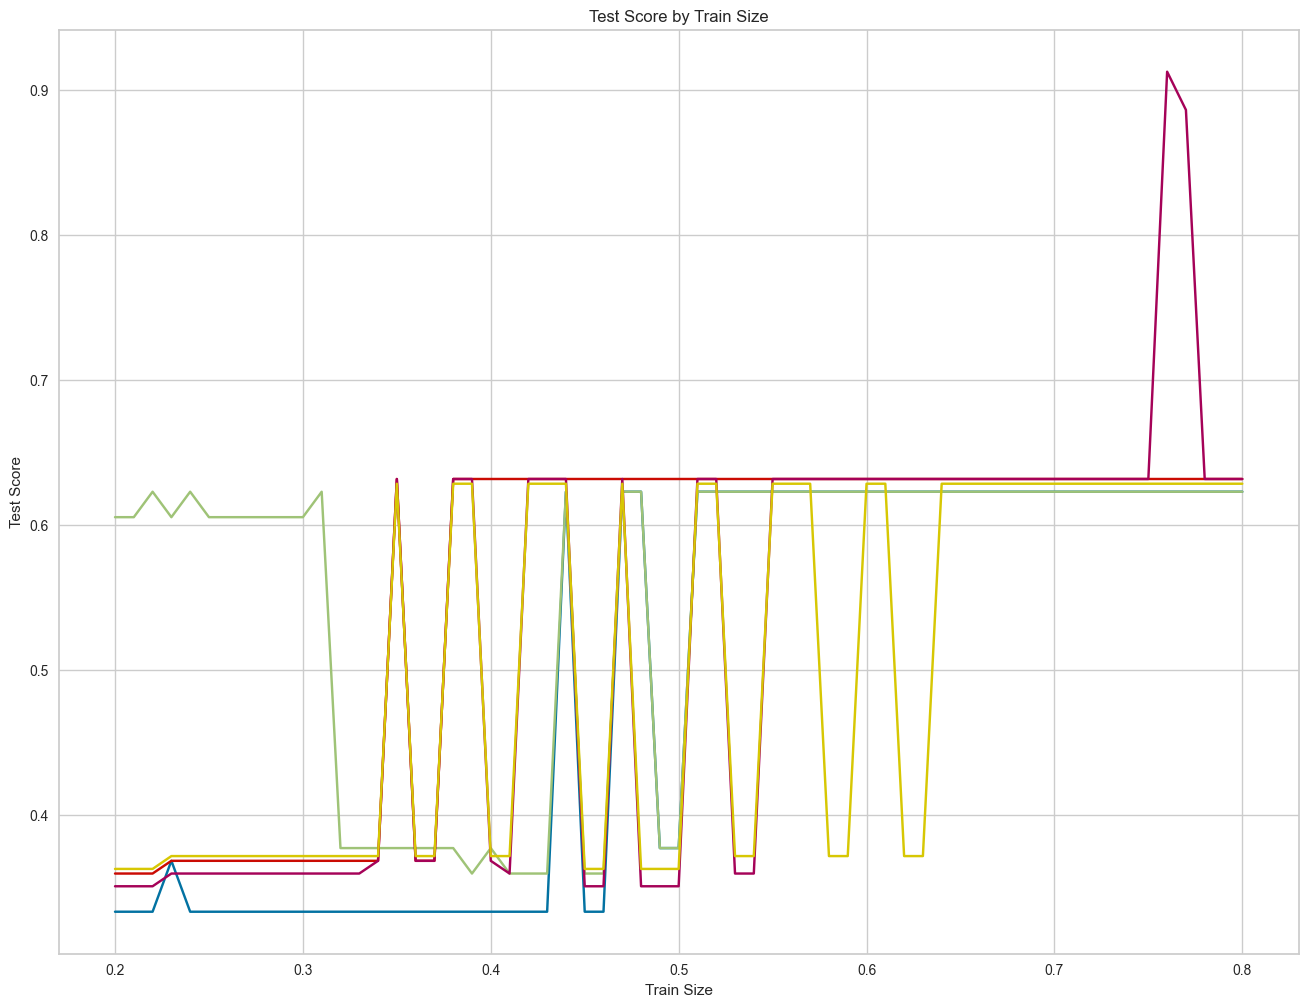

In [239]:
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(111)
ax.plot(train_sizes, test_scores)
ax.set_title("Test Score by Train Size")
ax.set_xlabel("Train Size")
ax.set_ylabel("Test Score")

In [213]:
# Neural Net on Reduced Data

X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
lossCurve1 = model.loss_curve_
valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
lossCurve2 = model.loss_curve_
valScore2 = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(pca_data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_data2, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
pca_lossCurve1 = model.loss_curve_
pca_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
pca_lossCurve2 = model.loss_curve_
pca_valScore2 = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(ica_data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(ica_data2, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
ica_lossCurve1 = model.loss_curve_
ica_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
ica_lossCurve2 = model.loss_curve_
ica_valScore2 = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(rp_data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(rp_data2, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
rp_lossCurve1 = model.loss_curve_
rp_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
rp_lossCurve2 = model.loss_curve_
rp_valScore2 = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(iso_data1, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(iso_data2, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
iso_lossCurve1 = model.loss_curve_
iso_valScore1 = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
iso_lossCurve2 = model.loss_curve_
iso_valScore2 = model.validation_scores_

30.9 ms ± 856 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
195 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.3 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
606 ms ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
90.4 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
406 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.1 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


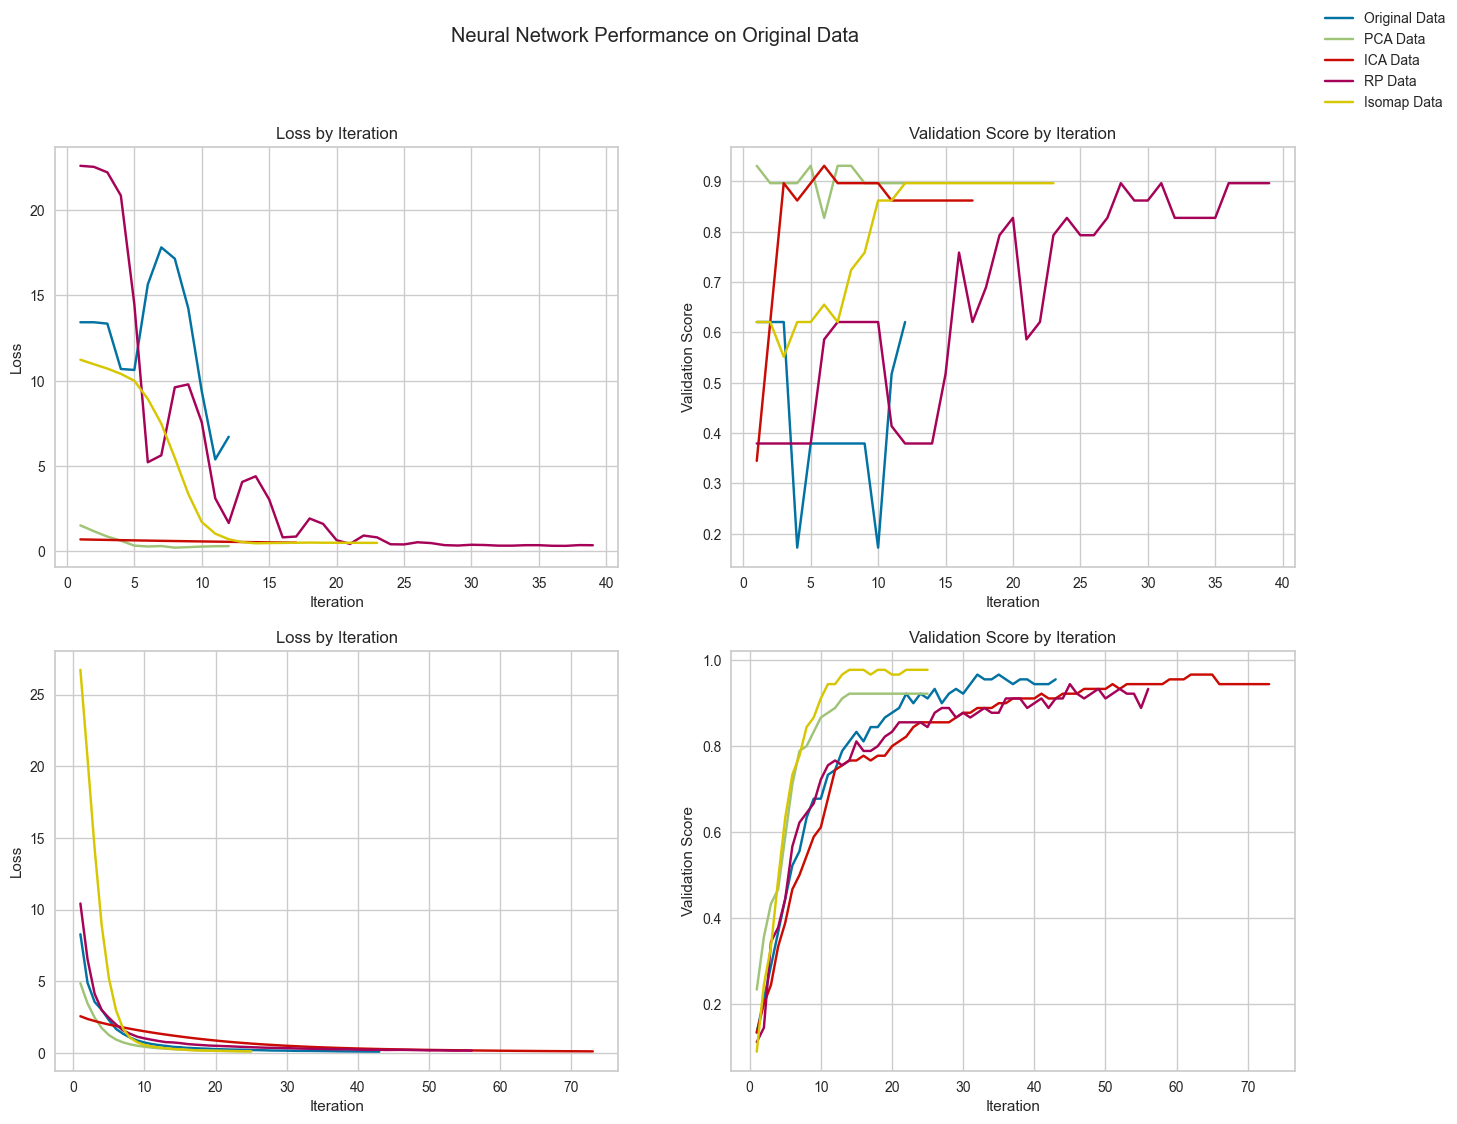

In [206]:
# DRA NN Viz

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.plot(np.arange(len(lossCurve1)) + 1, lossCurve1)
ax.plot(np.arange(len(pca_lossCurve1)) + 1, pca_lossCurve1)
ax.plot(np.arange(len(ica_lossCurve1)) + 1, ica_lossCurve1)
ax.plot(np.arange(len(rp_lossCurve1)) + 1, rp_lossCurve1)
ax.plot(np.arange(len(iso_lossCurve1)) + 1, iso_lossCurve1)
ax.set_title("Loss by Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(len(valScore1)) + 1, valScore1)
ax2.plot(np.arange(len(pca_valScore1)) + 1, pca_valScore1)
ax2.plot(np.arange(len(ica_valScore1)) + 1, ica_valScore1)
ax2.plot(np.arange(len(rp_valScore1)) + 1, rp_valScore1)
ax2.plot(np.arange(len(iso_valScore1)) + 1, iso_valScore1)
ax2.set_title("Validation Score by Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(len(lossCurve2)) + 1, lossCurve2)
ax3.plot(np.arange(len(pca_lossCurve2)) + 1, pca_lossCurve2)
ax3.plot(np.arange(len(ica_lossCurve2)) + 1, ica_lossCurve2)
ax3.plot(np.arange(len(rp_lossCurve2)) + 1, rp_lossCurve2)
ax3.plot(np.arange(len(iso_lossCurve2)) + 1, iso_lossCurve2)
ax3.set_title("Loss by Iteration")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4 = fig.add_subplot(224)
ax4.plot(np.arange(len(valScore2)) + 1, valScore2)
ax4.plot(np.arange(len(pca_valScore2)) + 1, pca_valScore2)
ax4.plot(np.arange(len(ica_valScore2)) + 1, ica_valScore2)
ax4.plot(np.arange(len(rp_valScore2)) + 1, rp_valScore2)
ax4.plot(np.arange(len(iso_valScore2)) + 1, iso_valScore2)
ax4.set_title("Validation Score by Iteration")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Reduced Data")
fig.legend(["Original Data", "PCA Data", "ICA Data", "RP Data", "Isomap Data"])

### NN Fitting on DRA with Clusters as Features

In [231]:
# Clusters as Features

data1_preds = np.vstack([em1Pred, km1Pred]).T
data2_preds = np.vstack([em2Pred, km2Pred]).T

data1_boosted = np.hstack([data1, data1_preds])
data2_boosted = np.hstack([data2, data2_preds])

pca_data1_boosted = np.hstack([pca_data1, data1_preds])
pca_data2_boosted = np.hstack([pca_data2, data2_preds])

ica_data1_boosted = np.hstack([ica_data1, data1_preds])
ica_data2_boosted = np.hstack([ica_data2, data2_preds])

rp_data1_boosted = np.hstack([rp_data1, data1_preds])
rp_data2_boosted = np.hstack([rp_data2, data2_preds])

iso_data1_boosted = np.hstack([iso_data1, data1_preds])
iso_data2_boosted = np.hstack([iso_data2, data2_preds])

In [233]:
# Neural Net on Reduced Data

X_train1, X_test1, y_train1, y_test1 = train_test_split(data1_boosted, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2_boosted, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
lossCurve1_boosted = model.loss_curve_
valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
lossCurve2_boosted = model.loss_curve_
valScore2_boosted = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(pca_data1_boosted, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_data2_boosted, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
pca_lossCurve1_boosted = model.loss_curve_
pca_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
pca_lossCurve2_boosted = model.loss_curve_
pca_valScore2_boosted = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(ica_data1_boosted, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(ica_data2_boosted, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
ica_lossCurve1_boosted = model.loss_curve_
ica_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
ica_lossCurve2_boosted = model.loss_curve_
ica_valScore2_boosted = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(rp_data1_boosted, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(rp_data2_boosted, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
rp_lossCurve1_boosted = model.loss_curve_
rp_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
rp_lossCurve2_boosted = model.loss_curve_
rp_valScore2_boosted = model.validation_scores_

X_train1, X_test1, y_train1, y_test1 = train_test_split(iso_data1_boosted, target1, stratify=target1, random_state=1, train_size=0.5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(iso_data2_boosted, target2, stratify=target2, random_state=1, train_size=0.5)

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train1, y_train1)
model.score(X_test1, y_test1)
iso_lossCurve1_boosted = model.loss_curve_
iso_valScore1_boosted = model.validation_scores_

%timeit model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model = MLPClassifier(random_state=1, max_iter=300, early_stopping=True).fit(X_train2, y_train2)
model.score(X_test2, y_test2)
iso_lossCurve2_boosted = model.loss_curve_
iso_valScore2_boosted = model.validation_scores_

49.2 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
391 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
74.2 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
594 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
499 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
36.6 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
413 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.1 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
259 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


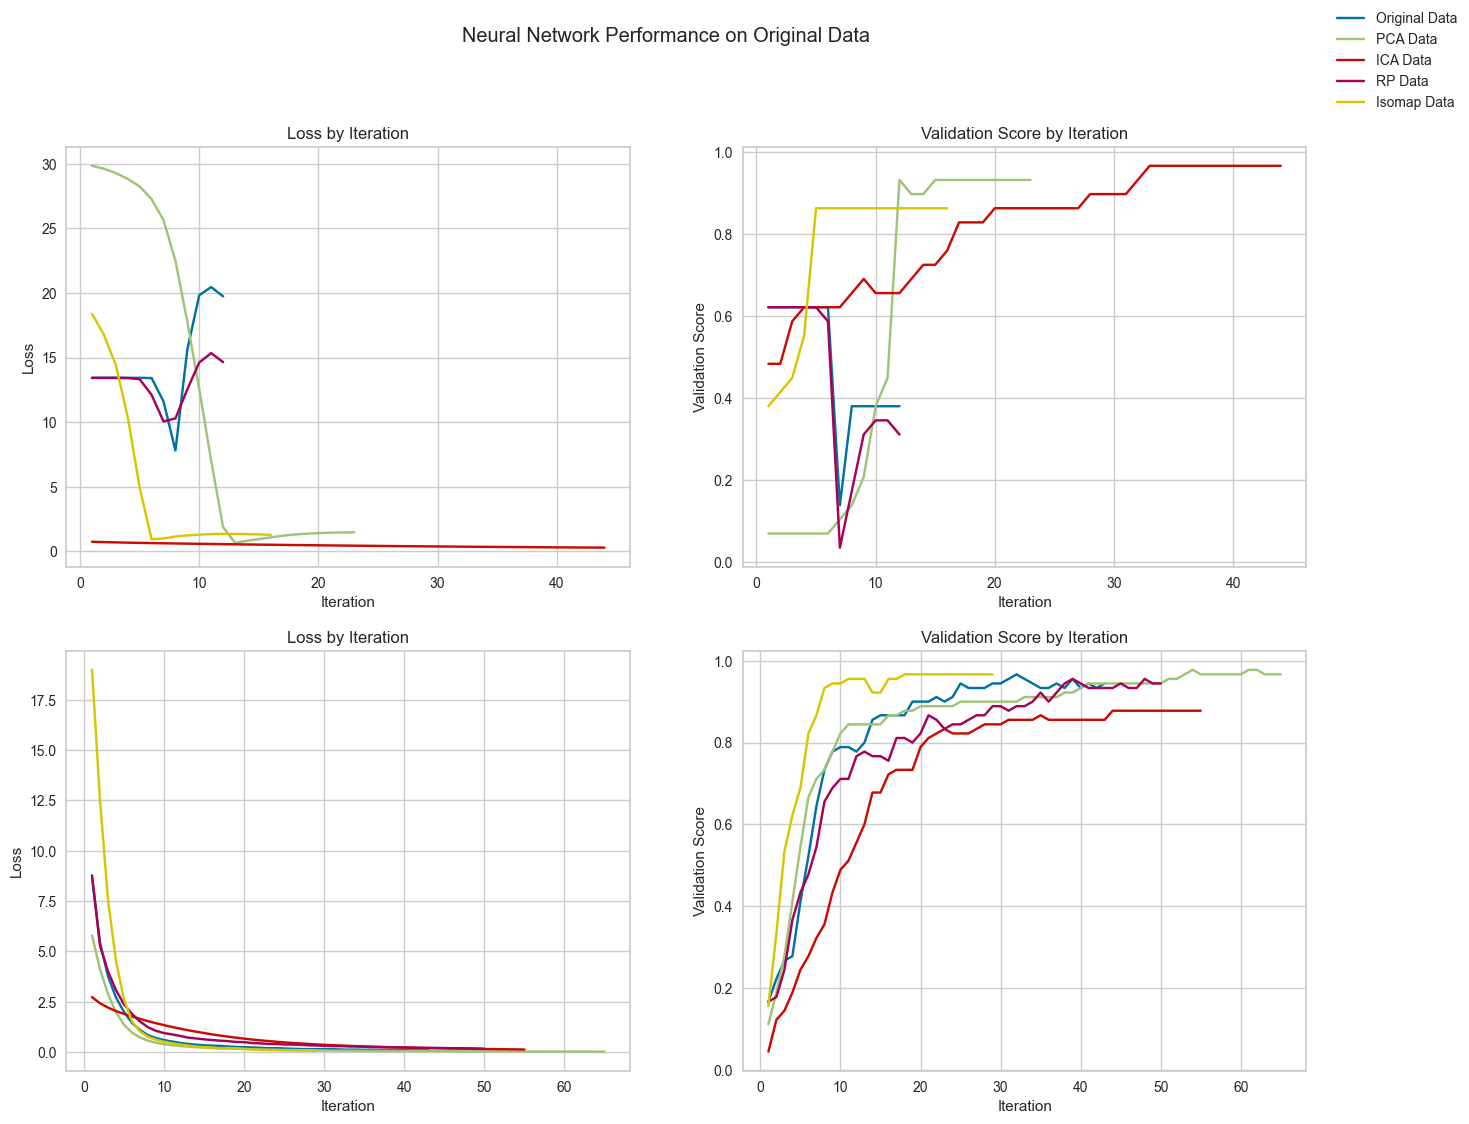

In [234]:
# DRA NN Viz

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.plot(np.arange(len(lossCurve1_boosted)) + 1, lossCurve1_boosted)
ax.plot(np.arange(len(pca_lossCurve1_boosted)) + 1, pca_lossCurve1_boosted)
ax.plot(np.arange(len(ica_lossCurve1_boosted)) + 1, ica_lossCurve1_boosted)
ax.plot(np.arange(len(rp_lossCurve1_boosted)) + 1, rp_lossCurve1_boosted)
ax.plot(np.arange(len(iso_lossCurve1_boosted)) + 1, iso_lossCurve1_boosted)
ax.set_title("Loss by Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(len(valScore1_boosted)) + 1, valScore1_boosted)
ax2.plot(np.arange(len(pca_valScore1_boosted)) + 1, pca_valScore1_boosted)
ax2.plot(np.arange(len(ica_valScore1_boosted)) + 1, ica_valScore1_boosted)
ax2.plot(np.arange(len(rp_valScore1_boosted)) + 1, rp_valScore1_boosted)
ax2.plot(np.arange(len(iso_valScore1_boosted)) + 1, iso_valScore1_boosted)
ax2.set_title("Validation Score by Iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Validation Score")

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(len(lossCurve2_boosted)) + 1, lossCurve2_boosted)
ax3.plot(np.arange(len(pca_lossCurve2_boosted)) + 1, pca_lossCurve2_boosted)
ax3.plot(np.arange(len(ica_lossCurve2_boosted)) + 1, ica_lossCurve2_boosted)
ax3.plot(np.arange(len(rp_lossCurve2_boosted)) + 1, rp_lossCurve2_boosted)
ax3.plot(np.arange(len(iso_lossCurve2_boosted)) + 1, iso_lossCurve2_boosted)
ax3.set_title("Loss by Iteration")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4 = fig.add_subplot(224)
ax4.plot(np.arange(len(valScore2_boosted)) + 1, valScore2_boosted)
ax4.plot(np.arange(len(pca_valScore2_boosted)) + 1, pca_valScore2_boosted)
ax4.plot(np.arange(len(ica_valScore2_boosted)) + 1, ica_valScore2_boosted)
ax4.plot(np.arange(len(rp_valScore2_boosted)) + 1, rp_valScore2_boosted)
ax4.plot(np.arange(len(iso_valScore2_boosted)) + 1, iso_valScore2_boosted)
ax4.set_title("Validation Score by Iteration")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Validation Score")

fig.suptitle("Neural Network Performance on Data with Step 1 Predictions")
fig.legend(["Original Data", "PCA Data", "ICA Data", "RP Data", "Isomap Data"])